# Example of custom metric

This example illustrates the usage of the custom distance metrics, by tracking segmented cells by their overlaps.

**Note that a simpler API for overlap tracking is implemented as `OverLapTrack` and illustrated [here](). This notebook uses custom metric only for the purpose of illustration.**

In [ ]:
%pip install -q --upgrade -r requirements.txt

## Importing packages

## Importing packages

`laptrack.LapTrack` is the core object for tracking. 

We also import `regionprops_table` from `skimage` to calculate centroids of the segmentation masks. 

To calculate the label overlaps, we import `LabelOverlap` from `laptrack.metric_utils` (requires `laptrack>=0.9.0`).

In [1]:
import napari
from skimage.measure import regionprops_table
from matplotlib import pyplot as plt
from itertools import product
import numpy as np
import pandas as pd
from laptrack import LapTrack
from laptrack.metric_utils import LabelOverlap

## Loading data 

Loading segmentation data and show it in the viewer.

Note: this data is generated by cropping `segmentation.npy` in https://github.com/NoneqPhysLivingMatterLab/cell_interaction_gnn .

In [2]:
labels = np.load("overlap_tracking_data/labels.npy")

In [3]:
viewer = napari.Viewer()
viewer.add_labels(labels)

<Labels layer 'labels' at 0x15d2eb370>

## Calculating segmentation overlaps 

`LabelOverlap` is an utility object to calculate the overlap between segmentation regions. 

In [4]:
lo = LabelOverlap(labels)

In [5]:
overlap_records = []
for f in range(labels.shape[0] - 1):
    print(f)
    l1s = np.unique(labels[f])
    l1s = l1s[l1s != 0]
    l2s = np.unique(labels[f + 1])
    l2s = l2s[l2s != 0]
    for l1, l2 in product(l1s, l2s):
        overlap, iou, ratio_1, ratio_2 = lo.calc_overlap(f, l1, f + 1, l2)
        overlap_records.append(
            {
                "frame": f,
                "label1": l1,
                "label2": l2,
                "overlap": overlap,
                "iou": iou,
                "ratio_1": ratio_1,
                "ratio_2": ratio_2,
            }
        )
overlap_df = pd.DataFrame.from_records(overlap_records)
overlap_df = overlap_df[overlap_df["overlap"] > 0]
overlap_df = overlap_df.set_index(["frame", "label1", "label2"]).copy()

0
1
2
3


`overlap_df` contains the overlap values between every label pairs. The paris with no overlap is ignored.

In [6]:
display(overlap_df.head())

overlap       iou   ratio_1   ratio_2
frame label1 label2                                       
0     1      5            88  0.232190  0.520710  0.295302
             8             9  0.017176  0.053254  0.024725
             13           54  0.091993  0.319527  0.114407
      2      1            16  0.050633  0.065306  0.183908
             8           187  0.443128  0.763265  0.513736

## Tracking 

### Create coordinate dataframe

Make the coordinate dataframe including `(frame, label)` to get the overlap data from `overlap_df` and the centroid to show the track data in the viewer.

In [7]:
dfs = []
for frame in range(len(labels)):
    df = pd.DataFrame(
        regionprops_table(labels[frame], properties=["label", "centroid"])
    )
    df["frame"] = frame
    dfs.append(df)
coordinate_df = pd.concat(dfs)
display(coordinate_df.head())

,label,centroid-0,centroid-1,frame
0,1,148.526627,2.278107,0
1,2,108.118367,3.742857,0
2,3,62.957143,2.964286,0
3,4,249.611111,0.222222,0
4,5,5.279279,3.927928,0


### Define metric function 

Here is the core of this example: we can define an arbitrary function as the metric to measure how points are close.

In this example, `metric` function retrive the pre-computed overlap between the segmented regions, and use

$$
1- \frac{\text{(label overlap between frame $t$ and $t+1$)}}{\text{(area at frame $t+1$)}}
$$

as the "distance" between the points.

In [8]:
def metric(c1, c2):
    (frame1, label1), (frame2, label2) = c1, c2
    if frame1 == frame2 + 1:
        tmp = (frame1, label1)
        (frame1, label1) = (frame2, label2)
        (frame2, label2) = tmp
    assert frame1 + 1 == frame2
    ind = (frame1, label1, label2)
    if ind in overlap_df.index:
        ratio_2 = overlap_df.loc[ind]["ratio_2"]
        return 1 - ratio_2
    else:
        return 1

### Execute tracking 

The defined `metric` function is used for the frame-to-frame linking (`track_dist_metric`), gap closing (`gap_closing_dist_metric`) and the splitting connection (`splitting_dist_metric`).

In [9]:
lt = LapTrack(
    track_dist_metric=metric,
    track_cost_cutoff=0.9,
    gap_closing_dist_metric=metric,
    gap_closing_max_frame_count=1,
    splitting_dist_metric=metric,
    splitting_cost_cutoff=0.9,
)

In [10]:
track_df, split_df, _ = lt.predict_dataframe(
    coordinate_df, coordinate_cols=["frame", "label"], only_coordinate_cols=False
)
track_df = track_df.reset_index()

In [11]:
display(track_df.head())
display(split_df.head())

,frame,index,label,centroid-0,centroid-1,frame_y,tree_id,track_id
0,0,0,1,148.526627,2.278107,0,0,0
1,0,1,2,108.118367,3.742857,0,1,1
2,0,2,3,62.957143,2.964286,0,2,2
3,0,3,4,249.611111,0.222222,0,3,3
4,0,4,5,5.279279,3.927928,0,4,4


,parent_track_id,child_track_id
0,1,133
1,1,132
2,11,134
3,11,137
4,14,138


## Showing clonal cells by the same colors

To check the result, we show the clonal cell regions by the same colors.

In [12]:
new_labels = np.zeros_like(labels)
for tree_id, grp in track_df.groupby("tree_id"):
    for _, row in grp.iterrows():
        frame = int(row["frame"])
        label = int(row["label"])
        new_labels[frame][labels[frame] == label] = tree_id + 1

In [13]:
viewer.layers["labels"].visible = False
viewer.add_labels(new_labels)

<Labels layer 'new_labels' at 0x1830139a0>

## Adding tracks connecting the centroids

To check the result, we add the tracks to to a `Tracks` layer.

In [14]:
viewer.add_tracks(
    track_df[["track_id", "frame", "centroid-0", "centroid-1"]].values,
    graph={
        row["child_track_id"]: row["parent_track_id"] for _, row in split_df.iterrows()
    },
    tail_length=1,
)

<Tracks layer 'Tracks' at 0x18a8b9240>

## Show screenshot

([], [])

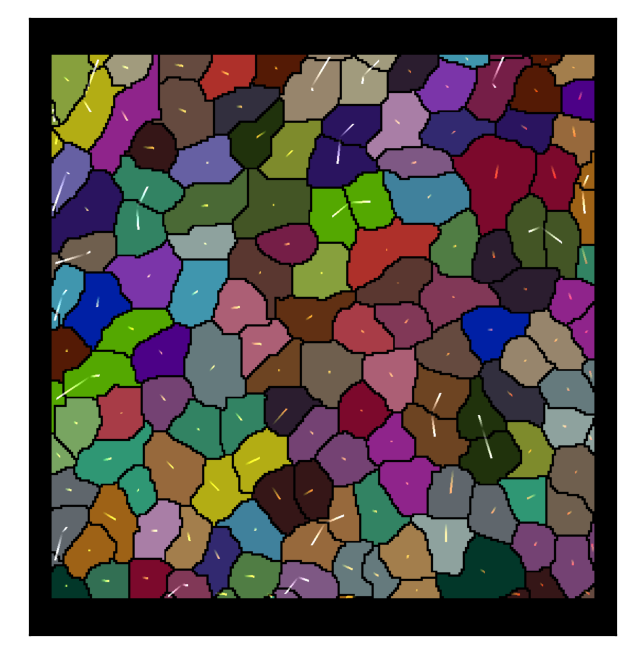

In [15]:
viewer.dims.current_step = (4, 0, 0)
plt.imshow(viewer.screenshot())
plt.xticks([])
plt.yticks([])